# Time series forecasting with FEDOT. Guide
#### FEDOT version = 0.2.1

[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This tutorial was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

"Nothing is clear but very interesting." - our lab's motto (but hope this tutorial will help you figure it out)

## Introduction 

A time series is a sequence of values ordered by time. For example, we can fix the value of a parameter at points in time $t, t+1, t+2$, etc. Various data can be represented as time series, e.g. the air temperature, the number of sales in the online store, the number of people who watch the stream on youtube, and much more. This series will look something like this (fig. 1).

<img src="../jupyter_media/time_series/time_series_simple.png" width="700"/>

Figure 1. What is time series and autoregression

An important feature of the time series is the "autoregression". As can be seen from fig. 1, elements from the past can have connections with future elements. The closer these elements are to each other, the stronger the connection, this is not always the case but very often. So, autoregression is the relationship between the elements of the time series. This feature of time series is used to predict future values when we know only past and current values. This task is called a time series forecasting.

Time series forecasting can be solved using autoregressive models from Python libraries, such as [statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html). However, this is still a challenging task. First of all, because even though time series forecasting models can give high results, but often require a researcher with high qualifications to adjust the hyperparameters.

But things get easier if you use FEDOT. Let's look at how values in time series can be predicted.

## Imports

In [1]:
# Additional imports are required
import os 

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.chains.node import PrimaryNode, SecondaryNode
from fedot.core.chains.ts_chain import TsForecastingChain

Let's take a closer look at what we imported from the FEDOT framework. The framework's functionality for time series forecasting is based on autoregressive models. We will use them below. The main meaning of such models can be shown in this picture (fig. 2)

<img src="../jupyter_media/time_series/autoregressive_models.png" width="1000"/>

Figure 2. Autoregressive models for time series forecasting

let's look at how such an autoregressive function works in a simple example

In [2]:
def simple_autoregression_function(dataframe):
    """
    The function trains a linear autoregressive model, 
    which use 2 predictors to give a forecast
    
    :param dataframe: pandas DataFrame with time series in "Values" column

    :return model: fitted linear regression model
    """
    
    # Take only values series
    vals = dataframe['Values']
    
    # Convert to lagged form (as in the picture above)
    lagged_dataframe = pd.concat([vals.shift(2), vals.shift(1), vals], axis=1)
    
    # Rename columns
    lagged_dataframe.columns = ['Predictor 1', 'Predictor 2', 'Target']
    
    # Drop na rows (first two rows)
    lagged_dataframe.dropna(inplace=True)
    
    # Display first five rows
    print(lagged_dataframe.head(4))
    
    # Get linear model to train
    model = LinearRegression()
    
    # Prepare features and target for model
    x_train = lagged_dataframe[['Predictor 1', 'Predictor 2']]
    y_train = lagged_dataframe['Target']
    
    # Fit the model
    model.fit(x_train, y_train)
    return model

let's build a simple model on a short time series.

In [3]:
# Prepare simple time series
example_dataframe = pd.DataFrame({'Values':[5,7,9,7,5,5,3,4,6,14,6,3,5]})

# Get fitted model
fitted_model = simple_autoregression_function(example_dataframe)

# Now we can forecast the values by knowing 
# the current and previous values (2 predictors in total)
predictors = [3,5]
print(f'\nPredictors: {predictors}')
forecast = fitted_model.predict([predictors])

print(f'Forecasted value: {forecast}')

   Predictor 1  Predictor 2  Target
2          5.0          7.0       9
3          7.0          9.0       7
4          9.0          7.0       5
5          7.0          5.0       5

Predictors: [3, 5]
Forecasted value: [7.51349541]


As can be seen from the example, in order to model the dependence between the elements of a time series, autoregressive models are needed. Here we have used linear regression, but we can approximate the dependence using nonlinear models (random forest for example) also.

But these models are not used directly in the framework. They are placed in containers called "nodes".

## Node
A node is where the model is placed.

In one such node, as in a container, we can put one model, which we want (the list of models will be presented below).

##### You can do it using a simple action:
    node_first = PrimaryNode('linear')
    
There are two types of nodes: 
* PrimaryNode - node where predictors are the source data;
* SecondaryNode - the node in which the predictors, prediction of the other nodes.

Schematically, it looks like this (fig. 3).

<img src="../jupyter_media/time_series/data_flow.png" width="900"/>

Figure 3. Differences between PrimaryNode and SecondaryNode. Demonstration of data flow in the chain.

## Chain
But using only single models is too easy. FEDOT can do much more. We can combine the nodes into chains - let's use Chain class.

Thus, if the model is wrapped in a node, the nodes are wrapped in chain. Below we will look in detail at how you can build such chains and what forecasts they can make.

<img src="../jupyter_media/time_series/chains_example.png" width="900"/>

Figure 4. Two examples of constructed chains

## Synthetic example

Below we will look at two examples of time series forecasting. On the example of artificially generated time series, and on the example of a real one.

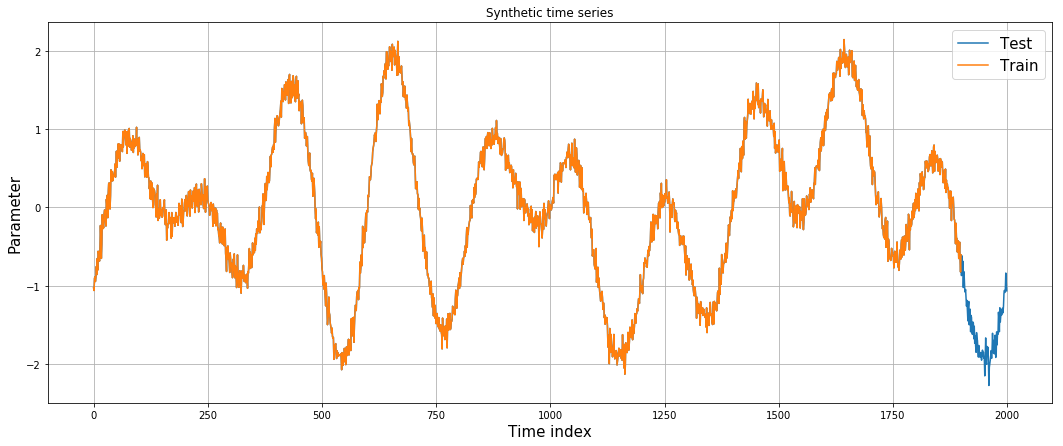

In [4]:
def generate_synthetic_data(length: int = 2000, periods: int = 10):
    """
    The function generates a synthetic univariate time series

    :param length: the length of the array (even number)
    :param periods: the number of periods in the sine wave

    :return synthetic_data: an array without gaps
    """

    # First component
    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    
    # Second component
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=0.1, size=length)

    # Combining a sine wave, cos wave and random noise
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    return synthetic_data

# Get such numpy array
synthetic_time_series = generate_synthetic_data()

# We will predict 100 values in the future
len_forecast = 100

# Let's dividide our data on train and test samples
train_data = synthetic_time_series[:-len_forecast]
test_data = synthetic_time_series[-len_forecast:]

# Plot time series
plt.plot(np.arange(0, len(synthetic_time_series)), synthetic_time_series, label = 'Test')
plt.plot(np.arange(0, len(train_data)), train_data, label = 'Train')
plt.ylabel('Parameter', fontsize = 15)
plt.xlabel('Time index', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Synthetic time series')
plt.grid()
plt.show()

### Data preparation

FEDOT is a multi-functional framework that allows you to solve classification, regression, and clustering problems. Moreover, with FEDOT, you can use specific methods, such as time series forecasting. But to do this we need to get acquainted with two more entities:
* Task - the task that the chain will solve;
* InputData - data that is used for training and prediction.

Thus, to solve the problem, we must choose a model (or several models), put them in chain, define the Task as a time series forecasting, and put the input data in the InputData wrapper.

> Why do we need so much preparations?

The "chain" is a universal tool. In order for this universal tool to work well on a specific task, we have prepared a structure that helps the chain work effectively on a single task - we called it "Task". Here we will focus on the problem of time series forecasting - TaskTypesEnum.ts_forecasting.

FEDOT also has specific data preprocessing, so the data that is submitted to the input must be presented in a single format - "InputData".

In [5]:
# Here we define which task should we use, here we also define two main 
# hyperparameters: forecast_length and max_window_size
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast,
                                max_window_size=300,
                                return_all_steps=False,
                                make_future_prediction=True))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_data)),
                        features=None,
                        target=train_data,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Make a "blank", here we need just help FEDOT understand that the 
# forecast should be made exactly the "len_forecast" length
predict_input = InputData(idx=np.arange(0, len_forecast),
                          features=None,
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

Let's focus on hyperparameters in more detail: 
* forecast_length - the length of the sequence (in elements) that we want to make a forecast for;
* max_window_size - moving window size.

The "forecast_length" is just forecast of what length we want to build - it's clear, nothing more. But what is "max_window_size"? - When we run the algorithm, we determine how many previous values will affect the forecast, that is, how many predictors there will be (fig. 5).

<img src="../jupyter_media/time_series/window_sizes.png" width="900"/>

Figure 5. An example of the different window sizes

Below is an animation that shows how the entire process takes place from the formation of a training sample to the forecast for several values ahead (max_window_size = 3, forecast_length = 3):

<img src="../jupyter_media/time_series/animation_forecast.gif" width="900"/>

Thus, the predictions as we move forward become predictors for the subsequent forecast. 

### Single model

Now we can choose such models as (below is not the entire list):
* linear - linear regression
* lasso - lasso regression
* ridge - ridge regression
* dtreg - decision tree regression
* rfr - random forest regression  
* knnreg - k-nearest neighbors regression

In [6]:
# Prepare chain
single_model = TsForecastingChain(PrimaryNode('ridge'))

# Fit it
single_model.fit_from_scratch(train_input)

# Predict
predicted_values = single_model.forecast(initial_data=train_input,
                                         supplementary_data=predict_input).predict

In [7]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

Now let's use the function to draw graphs and look at the result

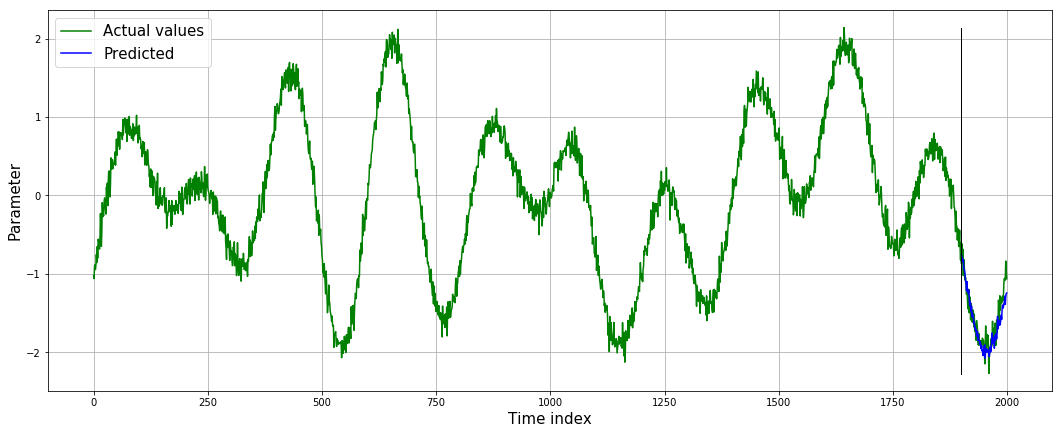

In [8]:
plot_results(actual_time_series = synthetic_time_series,
             predicted_values = predicted_values, 
             len_train_data = len(train_data))

As can be seen from the graph, the algorithm predict values very accurately. 

## Wrap-function for forecasting

Let's wrap our code into function, which will help us change some hyperparmeters. At the same time, let's look at what the whole process of building a model looks like.

In [9]:
def make_forecast(chain, train_data, len_forecast: int, max_window_size: int):
    """
    Function for predicting values in a time series
    
    :param chain: TsForecastingChain object
    :param train_data: one-dimensional numpy array to train chain
    :param len_forecast: amount of values for predictions
    :param max_window_size: moving window size

    :return predicted_values: numpy array, forecast of model
    """
    
    # Here we define which task should we use, here we also define two main 
    # hyperparameters: forecast_length and max_window_size
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast,
                                    max_window_size=max_window_size,
                                    return_all_steps=False,
                                    make_future_prediction=True))

    # Prepare data to train the model
    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=None,
                            target=train_data,
                            task=task,
                            data_type=DataTypesEnum.ts)

    # Make a "blank", here we need just help FEDOT understand that the 
    # forecast should be made exactly the "len_forecast" length
    predict_input = InputData(idx=np.arange(0, len_forecast),
                              features=None,
                              target=None,
                              task=task,
                              data_type=DataTypesEnum.ts)

    # Fit it
    chain.fit_from_scratch(train_input)

    # Predict
    predicted_values = chain.forecast(initial_data=train_input,
                                      supplementary_data=predict_input).predict
    
    return predicted_values

In the synthetic example, even a single model does very well - here we don't even need composite model (chain with several model). Let's change the window size and try to predict 200 values ahead

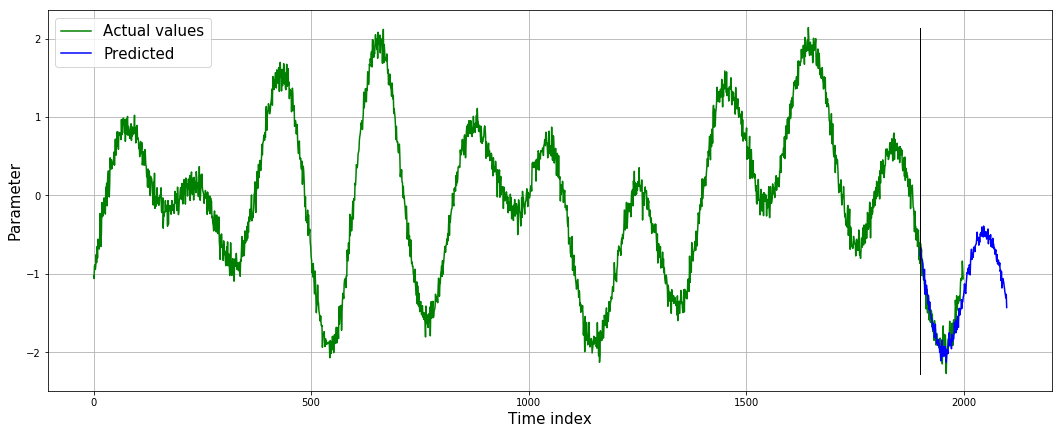

In [10]:
predicted_values = make_forecast(chain = TsForecastingChain(PrimaryNode('ridge')),
                                 train_data = train_data, 
                                 len_forecast = 200,
                                 max_window_size = 400)

plot_results(actual_time_series = synthetic_time_series,
             predicted_values = predicted_values, 
             len_train_data = len(train_data))

It looks good, but can Fedot handle real data? - Check it out!

## Real case. The height of the sea surface

Data was taken from a single cell of dataset "Sea level daily gridded data from satellite altimetry for the global ocean from 1993 to present". The full size dataset is available via [link](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview). A time series with daily resolution of the sea surface height above the average surface of the geoid was prepared. Dataset contains 3 columns:
* Date;
* Level - sea surface height at the point with coordinates 10°N 120°W (WGS84), m;
* Neighboring level - sea surface height at the point with coordinates 10°N 121°W (WGS84), m.

### Load example data

Let's load the sea level data and try to predict the 250 next values.

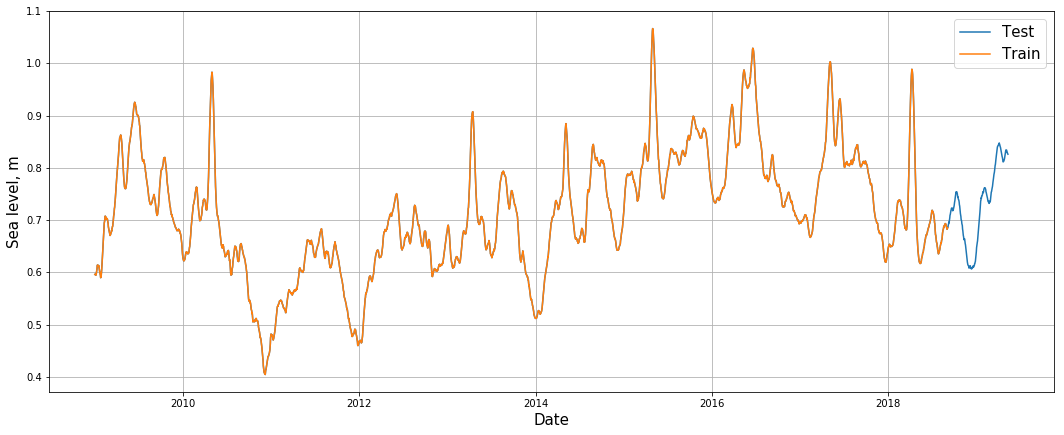

In [11]:
# Read thw file
df = pd.read_csv('./jupyter_media/time_series_forecasting/sea_level.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Specify forecast length
len_forecast = 250

# Got train, test parts, and the entire data
true_values = np.array(df['Level'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

plt.plot(df['Date'], true_values, label = 'Test')
plt.plot(df['Date'][:-len_forecast], train_array, label = 'Train')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

## Single model

Now let's prepare a chain of single model and try to predict the values

In [12]:
# Define chain
single_model = TsForecastingChain(PrimaryNode('ridge'))

# Make predictions
predicted_values = make_forecast(chain = single_model,
                                 train_data = train_array, 
                                 len_forecast = len_forecast,
                                 max_window_size = 100)

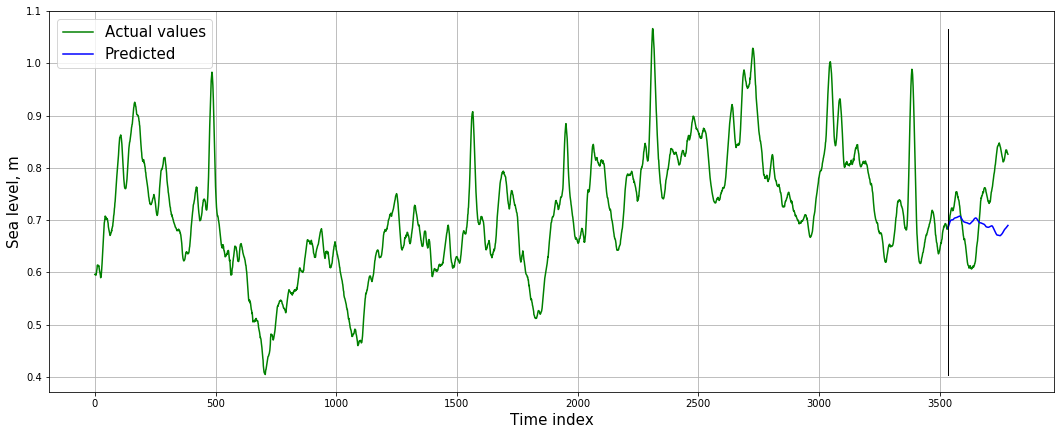

Mean absolute error: 0.072


In [13]:
# Plot predictions and true values
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Sea level, m')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

Well, we can see that it is much more difficult to deal with real data, not synthetic one. Let's change the window size.

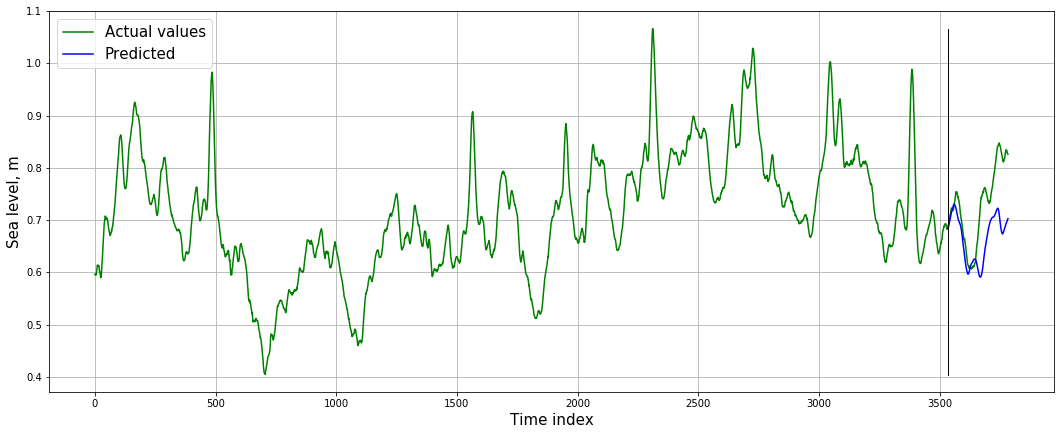

Mean absolute error: 0.063


In [14]:
# Define chain
single_model = TsForecastingChain(PrimaryNode('ridge'))

# Make predictions
predicted_values = make_forecast(chain = single_model,
                                 train_data = train_array, 
                                 len_forecast = len_forecast,
                                 max_window_size = 400)

# Plot predictions and true values
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Sea level, m')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

##### Much better, but FEDOT can do more! 

### Chain with models

Running the preprocessing and task preparation code below is no different. The important difference here is only in the definition of the chain.

In [15]:
# Define PrimaryNode models - its first level models
node_first = PrimaryNode('trend_data_model')
node_second = PrimaryNode('residual_data_model')

# Define SecondaryNode models - its second level models
node_trend_model = SecondaryNode('ridge', nodes_from=[node_first])
node_residual_model = SecondaryNode('ridge', nodes_from=[node_second])

# Root node - make final prediction
node_final = SecondaryNode('svr', nodes_from=[node_trend_model,
                                              node_residual_model])
final_chain = TsForecastingChain(node_final)

Using the nodes_from argument, you can determine from which nodes the selected node will receive predictions. The prepared chain looks as follows

<img src="../jupyter_media/time_series/trend_and_resid.png" width="500"/>

Figure 6. 5-node chain for time series forecasting

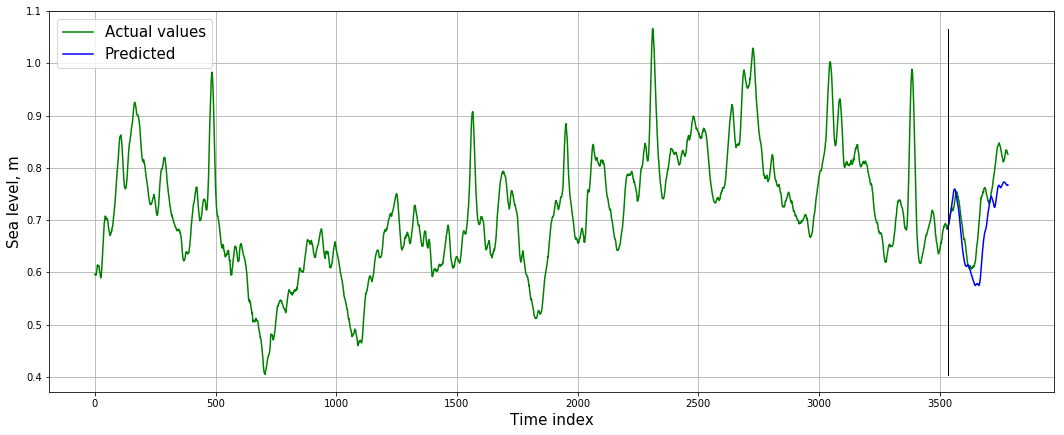

Mean absolute error: 0.045


In [16]:
predicted_values = make_forecast(chain = final_chain,
                                 train_data = train_array, 
                                 len_forecast = len_forecast,
                                 max_window_size = 900)

# Plot predictions and true values
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Sea level, m')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

## Exogenous variables

We still have the time series forecasting task, but we want to use additional information. For example, sea level data from a nearby point. We can do it.

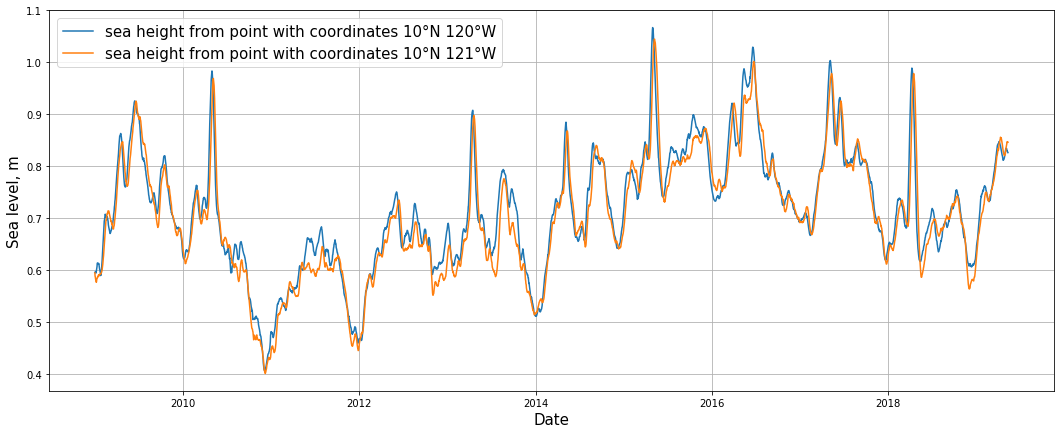

In [17]:
# Plot two time series
plt.plot(df['Date'], df['Level'], label = 'sea height from point with coordinates 10°N 120°W')
plt.plot(df['Date'], df['Neighboring level'], label = 'sea height from point with coordinates 10°N 121°W')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

Let's remember all the important aspects before training the model

In [18]:
# Specify forecast length
len_forecast = 250
max_window_size = 330

# Got train, test parts, and the entire data
true_values = np.array(df['Level'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

Prepare an exogenous time series for train model and for prediction.

In [19]:
exog_arr = np.array(df['Neighboring level'])
exog_train = exog_arr[:-len_forecast]
exog_test = exog_arr[-len_forecast:]

Let's try using only a chain of one model to make a prediction more accurate using an exogenous variable than prediction from chain of models, but without using an exogenous time series.

In [20]:
# Define single-node chain one more time
chain = TsForecastingChain(PrimaryNode('linear'))

# Here we define which task should we use, here we also define two main 
# hyperparameters: forecast_length and max_window_size
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast,
                                max_window_size=max_window_size,
                                return_all_steps=False,
                                make_future_prediction=True))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=exog_train,
                        target=train_array,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Make a "blank", here we need just help FEDOT understand that the 
# forecast should be made exactly the "len_forecast" length
predict_input = InputData(idx=np.arange(0, len_forecast),
                          features=exog_test,
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

# Fit it
chain.fit_from_scratch(train_input)

# Predict
predicted_values = chain.forecast(initial_data=train_input,
                                  supplementary_data=predict_input).predict

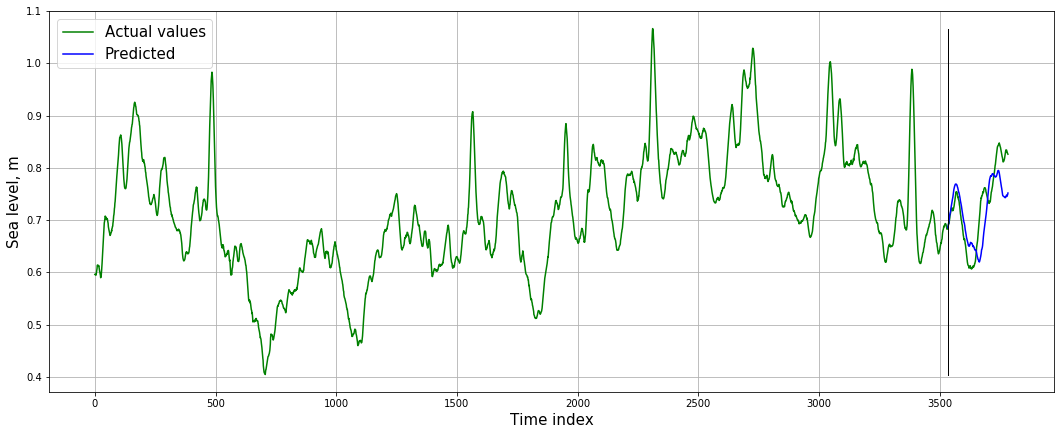

Mean absolute error: 0.041


In [21]:
# Plot predictions and true values
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values, 
             len_train_data = len(train_array),
             y_name = 'Sea level, m')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

Thus, you can build chains of any configuration and complexity. Good luck!